In [2]:
%matplotlib inline

import os
import gc
from time import time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix

if os.getcwd().find('kaggle') != -1:
    os.chdir('/kaggle/input/')
    from knnlib import KNNClassifier
    from knnlib import knn_cross_val_score, get_score
    from knnlib import aug, aug_X_y, transform
    os.chdir('/kaggle/working')
else:
    from knnlib import KNNClassifier
    from knnlib import knn_cross_val_score, get_score
    from knnlib import aug, aug_X_y, transform

In [3]:
if 'saved_bins' not in os.listdir():
    os.mkdir('saved_bins')
    print("creating 'saved_bins'")

In [4]:
X, y = fetch_openml('mnist_784', return_X_y=True)
n_features = X.shape[1]
train_size = 60000
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]
# X_train, y_train = X[:1000], y[:1000]
# X_test, y_test = X[1000:1100], y[1000:1100]
gc.collect()

0

# 1

In [5]:
rng = np.random.default_rng(seed=0)
strategies = ['my_own', 'brute', 'kd_tree', 'ball_tree']
features_lens = [10, 20, 50, 100, 340, 560, 784]
n_neighbors = 5
n_repeats = 3
times_features = np.empty((
    len(strategies),
    len(features_lens),
    n_repeats,
), dtype=float)

In [5]:
for i, n_used_features in enumerate(features_lens):
    print(f'Number of features: {n_used_features}')
    if n_used_features == n_features:
        used_features = np.s_[:]
    else:
        used_features = rng.choice(n_features, n_used_features, replace=False)
    for j, strategy in enumerate(strategies):
        print(f'  {strategy}')
        print('    its:')
        for k in range(n_repeats):
            print(f' {k}', end='')
            clf = KNNClassifier(n_neighbors, strategy=strategy,
                                test_block_size=1000)

            start = time()
            clf.fit(X_train[:, used_features], y_train)
            clf.find_kneighbors(X_test[:, used_features])
            finish = time()
            times_features[j, i, k] = finish - start

        print('  ok!')

print(f'Total: {times_features.sum():.2f} seconds')
np.save('saved_bins/1_times_features', times_features, allow_pickle=False)

Number of features: 10
  my_own
    its:
 0 1 2  ok!
  brute
    its:
 0 1 2  ok!
  kd_tree
    its:
 0 1 2  ok!
  ball_tree
    its:
 0 1 2  ok!
Number of features: 20
  my_own
    its:
 0 1 2  ok!
  brute
    its:
 0 1 2  ok!
  kd_tree
    its:
 0 1 2  ok!
  ball_tree
    its:
 0 1 2  ok!
Number of features: 50
  my_own
    its:
 0 1 2  ok!
  brute
    its:
 0 1 2  ok!
  kd_tree
    its:
 0 1 2  ok!
  ball_tree
    its:
 0 1 2  ok!
Number of features: 100
  my_own
    its:
 0 1 2  ok!
  brute
    its:
 0 1 2  ok!
  kd_tree
    its:
 0 1 2  ok!
  ball_tree
    its:
 0 1 2  ok!
Number of features: 340
  my_own
    its:
 0 1 2  ok!
  brute
    its:
 0 1 2  ok!
  kd_tree
    its:
 0 1 2  ok!
  ball_tree
    its:
 0 1 2  ok!
Number of features: 560
  my_own
    its:
 0 1 2  ok!
  brute
    its:
 0 1 2  ok!
  kd_tree
    its:
 0 1 2  ok!
  ball_tree
    its:
 0 1 2  ok!
Number of features: 784
  my_own
    its:
 0 1 2  ok!
  brute
    its:
 0 1 2  ok!
  kd_tree
    its:
 0 1 2  ok!
  ball_

In [6]:
plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='grey', ls=':')
plt.rc('image', cmap='Greys', interpolation='none')
plt.rc('font', family='serif')
plt.rc('font', serif='PT Serif')
plt.rc('savefig', bbox='tight', pad_inches=0.1)

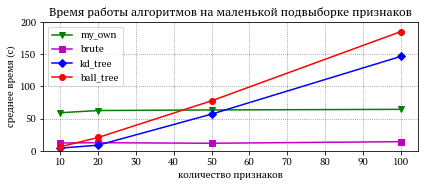

In [388]:
times_features = np.load('saved_bins/1_times_features.npy', allow_pickle=False)
tmeans = times_features.mean(axis=-1)
colors = ['g', 'm', 'b', 'r']
markers = ['v', 's', 'D', 'o']
fig, ax = plt.subplots(figsize=(6,2.7))
ax.grid(linestyle=':')
ax.set_title('Время работы алгоритмов на маленькой подвыборке признаков')
for mn, c, m in zip(tmeans, colors, markers):
    ax.plot(features_lens[:4], mn[:4], c=c, marker=m)
ax.set_xticks(np.arange(10, 101, 10))
ax.legend(strategies)
ax.set_xlabel('количество признаков')
ax.set_ylabel('среднее время (с)')
ax.set_ylim(0, 200)
plt.tight_layout()
plt.savefig('vis/n1_1.pdf')

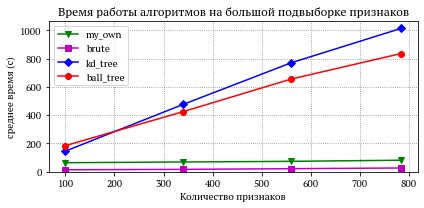

In [389]:
# times_features = np.load('saved_bins/1_times_features.npy', allow_pickle=False)
fig, ax = plt.subplots(figsize=(6,3))
ax.grid(color='gray', linestyle=':')
ax.set_title('Время работы алгоритмов на большой подвыборке признаков')
for mn, c, m in zip(tmeans, colors, markers):
    ax.plot(features_lens[3:], mn[3:], c=c, marker=m)
ax.set_xticks(np.arange(100, 900, 100))
ax.set_xlabel('Количество признаков')
ax.set_ylabel('среднее время (с)')
ax.set_ylim(0)
ax.legend(strategies)
plt.tight_layout()
plt.savefig('vis/n1_2.pdf')

# 2 и 3

In [21]:
def d_to_np(d):
    return np.array([row[1] for row in sorted([*d.items()])])

weights = [False, True]
strategies = ['my_own', 'brute']
features_len = 100
n_neighbors = list(range(1, 11))
metrics = ['euclidean', 'cosine']
n_repeats = 1

In [8]:
cv_times = np.empty((
    len(strategies),
    len(weights),
    len(metrics),
    len(n_neighbors),
    3,  # folds
), dtype=float)
cv_accs = np.empty_like(cv_times)

for i, strategy in enumerate(strategies):
    for j, weight in enumerate(weights):
        for k, metric in enumerate(metrics):
            print(strategy, weight, metric)
            ac, tm = knn_cross_val_score(X_train, y_train, k_list=n_neighbors,
                                        return_times=True, metric=metric,
                                        weights=weight,
                                        strategy=strategy, test_block_size=1000)
            cv_accs[i, j, k] = d_to_np(ac)
            cv_times[i, j, k] = d_to_np(tm)

np.save('saved_bins/23_cv_accs', cv_accs, allow_pickle=False)
np.save('saved_bins/23_cv_times', cv_times, allow_pickle=False)

my_own False euclidean
my_own False cosine
my_own True euclidean
my_own True cosine
brute False euclidean
brute False cosine
brute True euclidean
brute True cosine


Графики:

https://matplotlib.org/gallery/lines_bars_and_markers/fill_between_demo.html
https://github.com/Dyakonov/ml_hacks/blob/master/dj_explore_algoparameters.ipynb

In [30]:
cv_accs = np.load('saved_bins/23_cv_accs.npy', allow_pickle=False)
print(np.array_equal(cv_accs[0], cv_accs[1]))
cv_times = np.load('saved_bins/23_cv_times.npy', allow_pickle=False)

True


In [31]:
cv_accs = cv_accs[0].reshape((-1, 10, 3))
cvam = cv_accs.mean(axis=-1)
cvas = cv_accs.std(axis=-1)

In [49]:
cvam.max()

0.9741

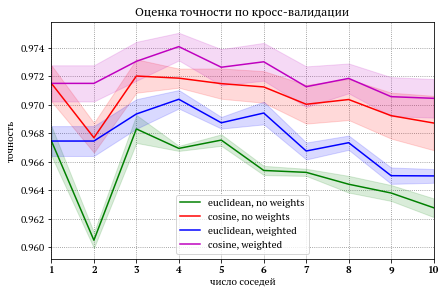

In [82]:
legend = [
    'euclidean, no weights',
    'cosine, no weights',
    'euclidean, weighted',
    'cosine, weighted',
]
colors = ['g', 'r', 'b', 'm']
fig, ax = plt.subplots(figsize=(6.3, 4.2), tight_layout=True)
ax.set_title('Оценка точности по кросс-валидации')
ax.set_ylabel('точность')
ax.set_xlabel('число соседей')
ax.set_xticks(n_neighbors)
ax.set_xticklabels(n_neighbors, fontweight='bold')
ax.set_xlim(1, 10)
for mn, st, c in zip(cvam, cvas, colors):
    ax.plot(n_neighbors, mn, c=c)
    ax.fill_between(n_neighbors, mn-st, mn+st, color=c, alpha=0.15)
ax.legend(legend)
plt.savefig('vis/n23_acc.pdf')

In [50]:
cv_times.mean(axis=-1).reshape((-1, 10))[:, 9]

array([103.19959927, 100.60356736, 204.85273004, 202.8000586 ,
        36.78001483,  38.90676252,  74.83046786,  77.55980698])

In [117]:
cvtm = cv_times.mean(axis=-1)
cvtms = [cvtm[0].reshape((-1, 10)), cvtm[1].reshape((-1, 10))]
alnames = ['my_own', 'brute']

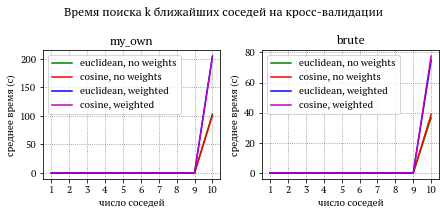

In [119]:
colors = ['g', 'r', 'b', 'm']
fig, axes = plt.subplots(1, 2, figsize=(6.3, 3), tight_layout=True)
fig.suptitle('Время поиска k ближайших соседей на кросс-валидации')
for ax, tms, nm in zip(axes, cvtms, alnames):
    ax.set_title(nm)
    for t, c in zip(tms, colors):
        ax.plot(n_neighbors, t, c=c)
    ax.set_xticks(n_neighbors)
    ax.set_xlabel('число соседей')
    ax.set_ylabel('среднее время (с)')
    ax.legend(legend)

plt.savefig('vis/n23_cv_times.pdf')

# 4

- Применить лучший алгоритм к исходной обучающей и тестовой выборке. Подсчитать **точность**. __ура, не время__ 
- Сравнить с точностью по кросс-валидации.
- Сравнить с указанной в интернете точностью лучших алгоритмовна данной выборке. 
- Построить и проанализировать матрицу ошибок (confusion matrix).
- Визуализировать несколько объектов из тестовой выборки, на которых были допущены ошибки. Проанализировать и указать их общие черты.

Замечания:
* Можно воспользоваться функцией sklearn.metrics.confusion_matrix.
* Для визуализации можно воспользоваться pyplot.subplot, и pyplot.imshow с параметром cmap="Greys". Также можно убрать оси координат при помощи команды pyplot.axis("off").

In [8]:
# %%timeit
best_params = {
    'k': 4,
    'strategy': 'brute',
    'metric': 'cosine',
    'weights': True,
    'test_block_size': 1000,
    'n_jobs': 1,
}
clf = KNNClassifier(**best_params)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
get_score('accuracy', y_test, y_pred)

0.9752

In [10]:
def to_freq(x):
    return x / x.sum()

In [137]:
to_freq(np.unique(y_train, return_counts=True)[1]).round(2)

array([0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.09, 0.1 , 0.1 , 0.1 , 0.1 ])

In [138]:
to_freq(np.unique(y_test, return_counts=True)[1]).round(2)

array([0.1 , 0.11, 0.1 , 0.1 , 0.1 , 0.09, 0.1 , 0.1 , 0.1 , 0.1 ])

Сравнить с:
* согласно https://paperswithcode.com/sota/image-classification-on-mnist, щас топ у
https://arxiv.org/abs/2001.09136 . 99.84 у ансамбля и 99.79 у отдельной модельки.

In [11]:
nums = np.arange(10)
cm = confusion_matrix(y_test, y_pred)

cm_stats = cm.copy()
np.fill_diagonal(cm_stats, 0)

# Табличка
sum_errs = cm_stats.sum(axis=1)
np.savetxt('4_table.csv', np.array([np.arange(10), sum_errs,
          (to_freq(sum_errs) * 100).round(2),
          (sum_errs / np.unique(y_test, return_counts=True)[1] * 100).round(2)]), fmt='%.2f')

In [214]:
cm_stats.sum(axis=0)

array([33, 24, 14, 25, 15, 21, 22, 24, 21, 49])

In [180]:
cb.set_ticklabels

<bound method ColorbarBase.set_ticklabels of <matplotlib.colorbar.Colorbar object at 0x7f281c6c6f10>>

In [192]:
np.arange(0, 31, 5)

array([ 0,  5, 10, 15, 20, 25, 30])

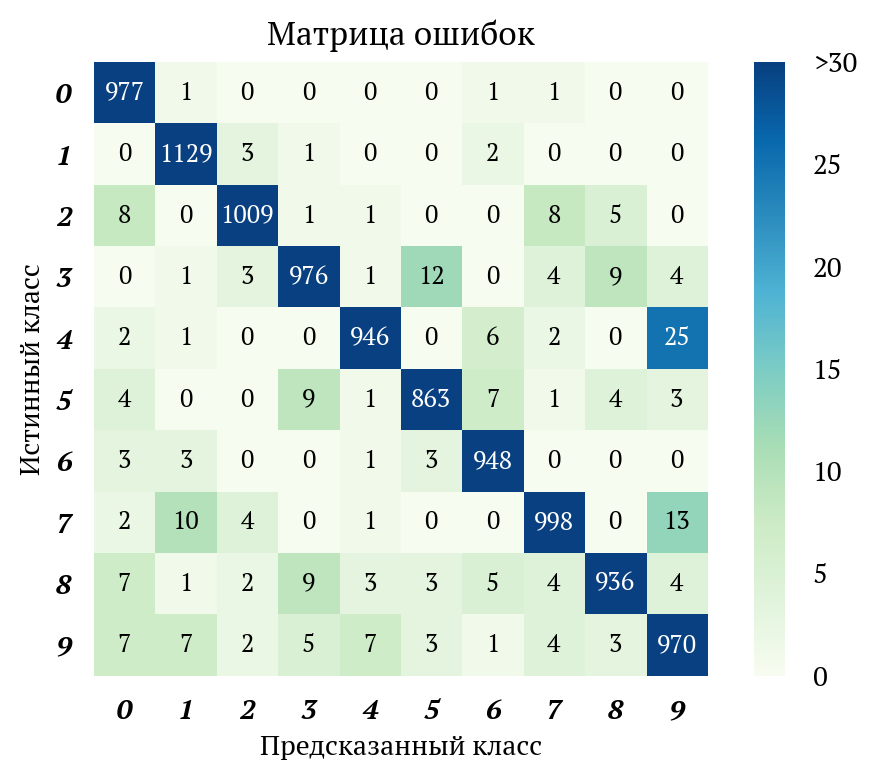

In [12]:
fig, ax = plt.subplots(figsize=(5,4), dpi=200, tight_layout=True)
im = ax.imshow(cm, vmax=30, cmap='GnBu', aspect='equal')
ax.grid([])
ax.set_xticks(nums)
ax.set_xticklabels(nums, fontstyle='italic', fontweight='bold')
ax.set_yticks(nums)
ax.set_yticklabels(nums, fontstyle='italic', fontweight='bold')
ax.set_xlabel('Предсказанный класс', labelpad=4)
ax.set_ylabel('Истинный класс', labelpad=4)
ax.set_title('Матрица ошибок')
for i in range(10):
    for j in range(10):
        color = 'white' if cm[j, i] > 20 else 'black'
        im.axes.text(i, j, cm[j, i], horizontalalignment='center',
        verticalalignment='center', c=color, fontsize=9)
cb = ax.figure.colorbar(im)
cb.outline.set_visible(False)
for spine in ax.spines.values():
        spine.set_visible(False)
ax.tick_params(length=0, pad=8)
cb.ax.tick_params(length=0, pad=10)
# cb.ax.set_yticklabels(['a'] * 7)
cticks = list(range(0, 31, 5))
cb.set_ticks(cticks)
cticks[-1] = '>30'
cb.set_ticklabels(cticks)
plt.savefig('vis/4_conf.pdf')

In [216]:
def error_images(i, X_test, y_test, y_pred):
    inds = ((y_test != y_pred) * (y_test == i)).nonzero()[0]
    images = X_test[inds].reshape((-1, 28, 28))
    return inds, images

 1


6


 3 2


[ 956 2182 2266 3073 4212 5331]


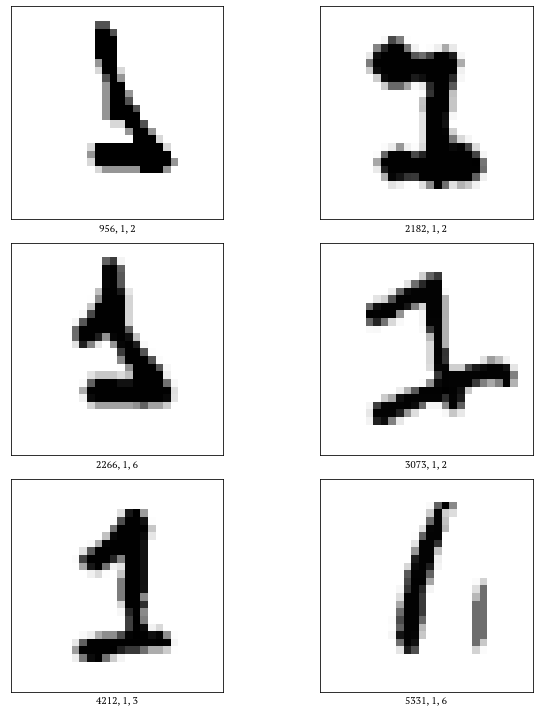

 9


39


 5 8


[ 241  320  448 1107 1192 1232 1247 1553 1559 1695 1901 2129 2293 2387
 2406 2648 2863 2939 3005 3369 3503 3597 3926 3985 4078 4163 4224 4500
 4761 4823 5001 6071 6081 6091 6157 6166 6172 6505 9642]


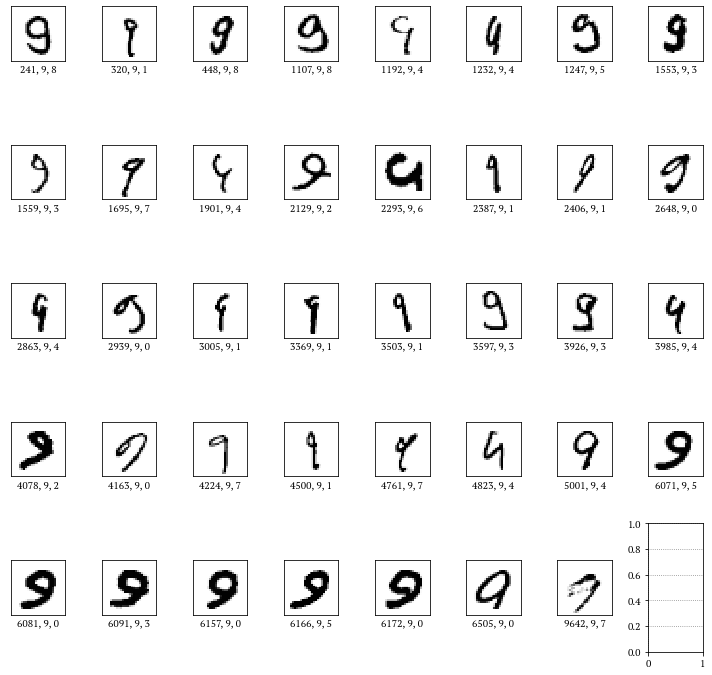

 -1


In [220]:
digit = input()
while digit != '-1':
    ers = error_images(digit, X_test, y_test, y_pred)
    print(len(ers[0]))
    rows, cols = (int(i) for i in input().split())
    fig, ax = plt.subplots(rows, cols, tight_layout=True, figsize=(10, 10))
    print(ers[0])
    for ind, im, curax in zip(ers[0], ers[1], ax.flatten()):
        curax.imshow(im, interpolation='none')
        curax.set_xticks([])
        curax.set_yticks([])
        curax.set_xlabel(f'{ind}, {y_test[ind]}, {y_pred[ind]}')
    plt.show()
    digit = input()

In [279]:
y_pred_bl = np.copy(y_pred)

In [223]:
(y_pred != y_test).nonzero()[0]

array([ 115,  241,  247,  320,  321,  358,  444,  445,  447,  448,  464,
        495,  551,  582,  591,  628,  707,  740,  839,  881,  924,  938,
        939,  947,  951,  956,  957, 1014, 1062, 1089, 1107, 1112, 1114,
       1178, 1192, 1226, 1232, 1242, 1247, 1260, 1290, 1299, 1319, 1325,
       1393, 1422, 1425, 1494, 1500, 1522, 1530, 1549, 1553, 1559, 1681,
       1695, 1721, 1737, 1778, 1790, 1865, 1878, 1901, 1955, 1970, 1984,
       2044, 2052, 2093, 2098, 2105, 2109, 2118, 2129, 2130, 2135, 2182,
       2224, 2237, 2266, 2272, 2293, 2298, 2299, 2339, 2387, 2395, 2406,
       2408, 2447, 2454, 2488, 2533, 2607, 2648, 2654, 2721, 2758, 2771,
       2810, 2863, 2896, 2901, 2927, 2939, 2952, 2953, 3005, 3062, 3073,
       3117, 3333, 3336, 3369, 3405, 3475, 3490, 3503, 3520, 3549, 3558,
       3559, 3597, 3629, 3702, 3780, 3796, 3808, 3811, 3838, 3853, 3893,
       3902, 3926, 3941, 3976, 3985, 4007, 4017, 4075, 4078, 4145, 4163,
       4176, 4194, 4199, 4212, 4224, 4289, 4306, 43

In [236]:
def show_imgs(inds, X_test, y_test, y_pred, fs=(6.3, 4)):
    ims = X_test[inds].reshape((-1, 28, 28))
    fig, ax = plt.subplots(1, len(inds), tight_layout=True, figsize=fs)
    for ind, im, curax in zip(inds, ims, ax.flatten()):
        curax.imshow(im, interpolation='none')
        curax.set_xticks([])
        curax.set_yticks([])
#         curax.set_xlabel(f'idx: {ind}\ntrue: {y_test[ind]}\npred: {y_pred[ind]}')
        curax.set_xlabel(f'true: {y_test[ind]}\npred: {y_pred[ind]}')
    return fig, ax

In [274]:
peculiar = [9634, 5331, 4176, 2927, 447, 1393, 1425]
similar = [2182, 3073, 2098, 1114, 5937, 1260, 358, 3985, 4823]
okay = [6035, 4212, 2299, 6035, 957]
bold = [1790, 3549, 8527, 8061, 495, 1553]
torot = [9211, 9669, 9745, 9792, 3117, 3520, 2118, 2896, 3559]
torot_nines = [6071, 6081, 6091, 6157, 6166, 6172]

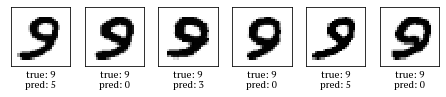

In [269]:
fig, ax = show_imgs(torot_nines, X_test, y_test, y_pred, fs=(6.3, 100))
plt.savefig('vis/4_nines_rot.pdf')

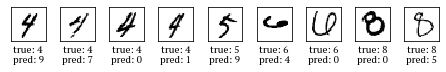

In [270]:
fig, ax = show_imgs(torot, X_test, y_test, y_pred, fs=(6.3, 100))
plt.savefig('vis/4_rot.pdf')

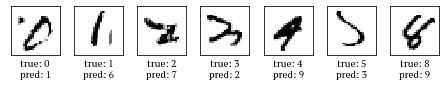

In [271]:
fig, ax = show_imgs(peculiar, X_test, y_test, y_pred, fs=(6.3, 100))
plt.savefig('vis/4_peculiar.pdf')

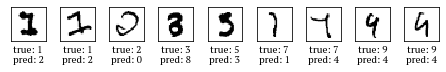

In [275]:
fig, ax = show_imgs(similar, X_test, y_test, y_pred, fs=(6.3, 100))
plt.savefig('vis/4_similar.pdf')

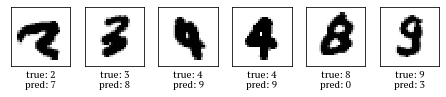

In [273]:
fig, ax = show_imgs(bold, X_test, y_test, y_pred, fs=(6.3, 100))
plt.savefig('vis/4_bold.pdf')

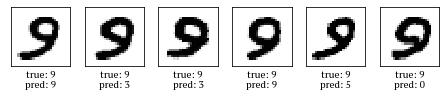

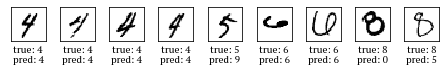

In [395]:
fig, ax = show_imgs(torot_nines, X_test, y_test, test_aug_5[0], fs=(6.3, 100))
fig, ax = show_imgs(torot, X_test, y_test, test_aug_5[1], fs=(6.3, 100))

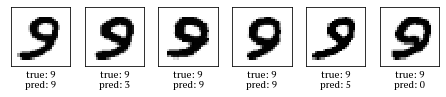

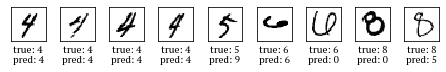

In [397]:
fig, ax = show_imgs(torot_nines, X_test, y_test, test_tta_6[0], fs=(6.3, 100))
fig, ax = show_imgs(torot, X_test, y_test, test_tta_6[1], fs=(6.3, 100))

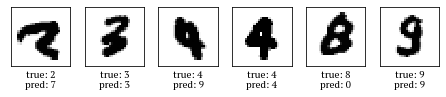

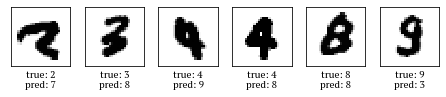

In [399]:
fig, ax = show_imgs(bold, X_test, y_test, test_aug_5[2], fs=(6.3, 100))
fig, ax = show_imgs(bold, X_test, y_test, test_tta_6[2], fs=(6.3, 100))

In [ ]:
Похожие на другие: 2182, 3073, 2098, 1114, 5937, 1260, 358, 947, 3985, 4823

Очень странные: 9634, 5331, 4176, 2927, 447, 1393, 1425

Хорошие, напрасно алгоритм ошибся: 4212, 2299, 6035, 957

Жирные: 6035, 1790, 3549, 8527, 8061, 495, 1553

идеально для поворота: 9211, 9669, 9745, 9792, 3117, 3520, 2118, 2896, 3559,
6071 6081 6091 6157 6166 6172

https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py
https://matplotlib.org/users/dflt_style_changes.html
https://matplotlib.org/3.3.2/tutorials/colors/colormaps.html

# 5
По кросс-валидации АУГМЕНТАЦИЯ:
* (a) Величина поворота: 5, 10, 15 (в каждую из двух сторон)
* (b) Величина смещения: 1, 2, 3 пикселя (по каждой из двух размерностей)
* (c) Дисперсия фильтра Гаусса: 0.5, 1, 1.5

и потом снова на тесте и снова конфьюжн и и снова примеры

In [5]:
trs = [
    [[('r', 5)], [('r', -5)]],
    [[('r', 10)], [('r', -10)]],
    [[('r', 15)], [('r', -15)]],
    [[('s', (1, 0))], [('s', (-1, 0))]],
    [[('s', (2, 0))], [('s', (-2, 0))]],
    [[('s', (3, 0))], [('s', (-3, 0))]],
    [[('s', (0, 1))], [('s', (0, -1))]],
    [[('s', (0, 2))], [('s', (0, -2))]],
    [[('s', (0, 3))], [('s', (0, -3))]],
    [[('g', 0.5)]],
    [[('g', 1)]],
    [[('g', 1.5)]],
]

In [6]:
def d_to_np(d):
    return np.array([row[1] for row in sorted([*d.items()])])

def_params = {
    'strategy': 'brute',
    'weights': True,
    'metric': 'cosine',
    'n_jobs': -1,
}
n_neighbors = list(range(1, 11))

In [7]:
aug_cv_accs = np.empty((
    len(trs),
    len(n_neighbors),
    3,  # folds
), dtype=float)
tta_cv_accs = np.empty_like(aug_cv_accs)

for i, tr in enumerate(trs):
    gc.collect()
    ac = knn_cross_val_score(X_train, y_train, k_list=n_neighbors,
                                return_times=False, aug=tr, **def_params)
    res = d_to_np(ac)
    print(tr)
    print(res.mean(axis=1))
    print()
    aug_cv_accs[i] = res

np.save('saved_bins/5_cv_accs', aug_cv_accs, allow_pickle=False)

[[('r', 5)], [('r', -5)]]
[0.97643333 0.97643333 0.97688333 0.97761667 0.97746667 0.9775
 0.97735    0.97731667 0.97678333 0.97676667]

[[('r', 10)], [('r', -10)]]
[0.9768     0.9768     0.97833333 0.97878333 0.97845    0.9787
 0.97768333 0.97808333 0.97723333 0.97745   ]

[[('r', 15)], [('r', -15)]]
[0.9751     0.9751     0.97681667 0.9776     0.97698333 0.97796667
 0.97661667 0.9769     0.97551667 0.97586667]

[[('s', (1, 0))], [('s', (-1, 0))]]
[0.97578333 0.97578333 0.97786667 0.97841667 0.97793333 0.97836667
 0.97763333 0.97803333 0.97693333 0.97731667]

[[('s', (2, 0))], [('s', (-2, 0))]]
[0.97256667 0.97256667 0.975      0.97616667 0.97461667 0.97538333
 0.97391667 0.97438333 0.97333333 0.97335   ]

[[('s', (3, 0))], [('s', (-3, 0))]]
[0.97195    0.97195    0.97363333 0.97475    0.97345    0.97393333
 0.97216667 0.97266667 0.97156667 0.97153333]

[[('s', (0, 1))], [('s', (0, -1))]]
[0.97496667 0.97496667 0.97688333 0.97768333 0.97678333 0.97745
 0.97638333 0.97666667 0.97538333 

In [9]:
def_params = {
    'strategy': 'my_own',
    'weights': True,
    'metric': 'cosine',
    'n_jobs': 1,
    'test_block_size': 10000,
}

tta_cv_accs = np.empty((
    len(trs),
    len(n_neighbors),
    3,  # folds
), dtype=float)

for i, tr in enumerate(trs):
    gc.collect()
    ac = knn_cross_val_score(X_train, y_train, k_list=n_neighbors,
                                return_times=False, tta=tr, **def_params)
    res = d_to_np(ac)
    print(tr)
    print(res.mean(axis=1))
    print()
    tta_cv_accs[i] = res

np.save('saved_bins/6_cv_accs', tta_cv_accs, allow_pickle=False)

[[('r', 5)], [('r', -5)]]
[0.9761     0.9761     0.97708333 0.97791667 0.9765     0.97708333
 0.97545    0.97566667 0.97435    0.97448333]

[[('r', 10)], [('r', -10)]]
[0.9764     0.9764     0.97768333 0.97851667 0.97738333 0.9777
 0.97631667 0.97683333 0.97551667 0.97593333]

[[('r', 15)], [('r', -15)]]
[0.97485    0.97485    0.97646667 0.9771     0.97661667 0.97715
 0.9759     0.97615    0.975      0.97518333]

[[('s', (1, 0))], [('s', (-1, 0))]]
[0.97576667 0.97576667 0.97773333 0.97846667 0.97723333 0.9776
 0.97681667 0.977      0.97601667 0.9761    ]

[[('s', (2, 0))], [('s', (-2, 0))]]
[0.97258333 0.97258333 0.975      0.97616667 0.97468333 0.97536667
 0.97396667 0.97438333 0.97321667 0.97335   ]

[[('s', (3, 0))], [('s', (-3, 0))]]
[0.9719     0.9719     0.97355    0.97471667 0.9734     0.97396667
 0.97223333 0.97266667 0.97161667 0.97151667]

[[('s', (0, 1))], [('s', (0, -1))]]
[0.97495    0.97495    0.97666667 0.97748333 0.97591667 0.97641667
 0.97505    0.97535    0.97401667 

In [286]:
baseline = np.load('saved_bins/23_cv_accs.npy', allow_pickle=False)[0, 1, 1]
bstd = baseline.std(axis=1)
bl = baseline.mean(axis=1)
blbt = (bl - bstd, bl + bstd)

In [297]:
trs

[[[('r', 5)], [('r', -5)]],
 [[('r', 10)], [('r', -10)]],
 [[('r', 15)], [('r', -15)]],
 [[('s', (1, 0))], [('s', (-1, 0))]],
 [[('s', (2, 0))], [('s', (-2, 0))]],
 [[('s', (3, 0))], [('s', (-3, 0))]],
 [[('s', (0, 1))], [('s', (0, -1))]],
 [[('s', (0, 2))], [('s', (0, -2))]],
 [[('s', (0, 3))], [('s', (0, -3))]],
 [[('g', 0.5)]],
 [[('g', 1)]],
 [[('g', 1.5)]]]

In [323]:
tr_legend = ['±5°', '±10°', '±15°', '±1', '±2', '±3', '±1',
             '±2', '±3', '$\sigma\,$=0.5', '$\sigma\,$=1', '$\sigma\,$=1.5']

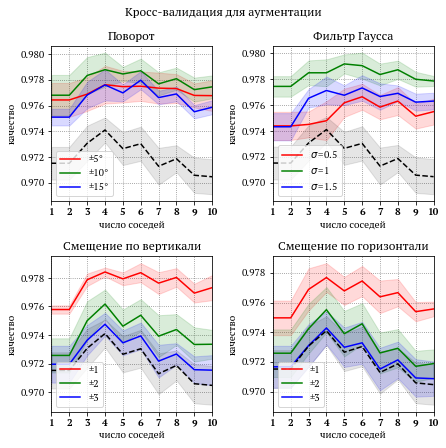

In [326]:
a_cv_accs = np.load('saved_bins/5_cv_accs.npy', allow_pickle=False)
acvam = a_cv_accs.mean(axis=-1)
acvas = a_cv_accs.std(axis=-1)

idx = [(0, 3), (9, 12), (3, 6), (6, 9)]
titles = ['Поворот', 'Фильтр Гаусса', 'Смещение по вертикали', 'Смещение по горизонтали']
colors = ['r', 'g', 'b'] * 4

fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(6.3, 6.3))
fig.suptitle('Кросс-валидация для аугментации')

for ax, k, (i, j) in zip(axes.flatten(), range(4), idx):
    ax.set_xticks(n_neighbors)
    ax.set_xticklabels(n_neighbors, fontweight='bold')
    ax.set_xlim(1, 10)
    ax.set_title(titles[k])
    ax.set_xlabel('число соседей')
    ax.set_ylabel('качество')
    for mn, st, c in zip(acvam[i:j], acvas[i:j], colors[i:j]):
        ax.plot(n_neighbors, mn, c=c)
        ax.fill_between(n_neighbors, mn-st, mn+st, color=c, alpha=0.15)
    ax.legend(tr_legend[i:j], loc='lower left')
    ax.plot(n_neighbors, bl, c='black', ls='--')
    ax.fill_between(n_neighbors, *blbt, color='black', alpha=0.1)
    # ax[k].legend(legend)
plt.savefig('vis/5_cv.pdf')

In [339]:
tr_r = [[('r', 10)], [('r', -10)]]
tr_s = [[('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))]]
tr_g = [[('g', 1)]]
tr_rs = tr_r + tr_s
tr_rg = tr_r + tr_g
tr_sg = tr_s + tr_g
tr_rsg = tr_s + tr_s + tr_g
list_of_trs = [tr_r, tr_s, tr_g, tr_rs, tr_rg, tr_sg, tr_rsg]

In [6]:
def_params = {
    'strategy': 'brute',
    'weights': True,
    'metric': 'cosine',
    'n_jobs': 1,
    'test_block_size': 5000,
}

In [7]:
test_aug_5 = np.empty((len(list_of_trs), len(y_test)), dtype=np.int)

for i, tr in enumerate(list_of_trs):
    print(i, tr)
    gc.collect()
    clf = KNNClassifier(k=4, aug=tr, **def_params)
    clf.fit(X_train, y_train)
    test_aug_5[i] = clf.predict(X_test)
    print(get_score('accuracy', y_test.astype(np.int), test_aug_5[i]))
    print()

np.save('saved_bins/test_aug_5', test_aug_5, allow_pickle=False)

0 [[('r', 10)], [('r', -10)]]
0.9802

1 [[('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))]]
0.9798

2 [[('g', 1)]]
0.9814

3 [[('r', 10)], [('r', -10)], [('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))]]
0.983

4 [[('r', 10)], [('r', -10)], [('g', 1)]]
0.9833

5 [[('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))], [('g', 1)]]
0.9836

6 [[('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))], [('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))], [('g', 1)]]
0.983



# 6
По кросс-валидации размножение теста:
* (a) Величина поворота: 5, 10, 15 (в каждую из двух сторон)
* (b) Величина смещения: 1, 2, 3 пикселя (по каждой из двух размерностей)
* (c) Дисперсия фильтра Гаусса: 0.5, 1, 1.5

* МАСШТАБИРОВАНИЕ!
* а еще можно 9 и 6 поменять

Тут параллельно:

https://scikit-image.org/docs/stable/user_guide/tutorial_parallelization.html

In [7]:
def dr(ax, a, reshape=True):
    b = a
    if reshape:
        b = a.reshape((28, 28))
    im = ax.imshow(b, cmap='Greys', aspect='equal', interpolation='none')
    ax.grid()
    ax.set_xticks(np.arange(-0.5, 28, 7))
    ax.set_yticks(np.arange(-0.5, 28, 7))
    return im


def before_after(X_old, X_new, idx, offset=0):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10), dpi=100)
    dr(ax[0], X_old[idx])
    dr(ax[1], X_new[idx + offset*len(X_old)])
    plt.savefig('test_digit.pdf')   

Дораспараллеливание было очень простым в силу прозрачной реализации взаимодействия с test_block_size. Достаточно было сделать цикл параллелльным, не забыв учесть ограничения :)

In [9]:
def_params = {
    'strategy': 'my_own',
    'weights': True,
    'metric': 'cosine',
    'n_jobs': 1,
    'test_block_size': 10000,
}

tta_cv_accs = np.empty((
    len(trs),
    len(n_neighbors),
    3,  # folds
), dtype=float)

for i, tr in enumerate(trs):
    gc.collect()
    ac = knn_cross_val_score(X_train, y_train, k_list=n_neighbors,
                                return_times=False, tta=tr, **def_params)
    res = d_to_np(ac)
    print(tr)
    print(res.mean(axis=1))
    print()
    tta_cv_accs[i] = res

np.save('saved_bins/6_cv_accs', tta_cv_accs, allow_pickle=False)

[[('r', 5)], [('r', -5)]]
[0.9761     0.9761     0.97708333 0.97791667 0.9765     0.97708333
 0.97545    0.97566667 0.97435    0.97448333]

[[('r', 10)], [('r', -10)]]
[0.9764     0.9764     0.97768333 0.97851667 0.97738333 0.9777
 0.97631667 0.97683333 0.97551667 0.97593333]

[[('r', 15)], [('r', -15)]]
[0.97485    0.97485    0.97646667 0.9771     0.97661667 0.97715
 0.9759     0.97615    0.975      0.97518333]

[[('s', (1, 0))], [('s', (-1, 0))]]
[0.97576667 0.97576667 0.97773333 0.97846667 0.97723333 0.9776
 0.97681667 0.977      0.97601667 0.9761    ]

[[('s', (2, 0))], [('s', (-2, 0))]]
[0.97258333 0.97258333 0.975      0.97616667 0.97468333 0.97536667
 0.97396667 0.97438333 0.97321667 0.97335   ]

[[('s', (3, 0))], [('s', (-3, 0))]]
[0.9719     0.9719     0.97355    0.97471667 0.9734     0.97396667
 0.97223333 0.97266667 0.97161667 0.97151667]

[[('s', (0, 1))], [('s', (0, -1))]]
[0.97495    0.97495    0.97666667 0.97748333 0.97591667 0.97641667
 0.97505    0.97535    0.97401667 

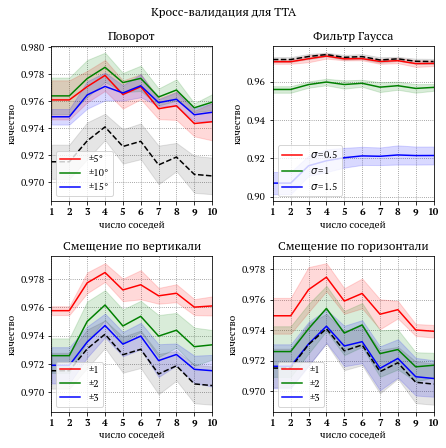

In [327]:
a_cv_accs = np.load('saved_bins/6_cv_accs.npy', allow_pickle=False)
acvam = a_cv_accs.mean(axis=-1)
acvas = a_cv_accs.std(axis=-1)

idx = [(0, 3), (9, 12), (3, 6), (6, 9)]
titles = ['Поворот', 'Фильтр Гаусса', 'Смещение по вертикали', 'Смещение по горизонтали']
colors = ['r', 'g', 'b'] * 4

fig, axes = plt.subplots(2, 2, tight_layout=True, figsize=(6.3, 6.3))
fig.suptitle('Кросс-валидация для TTA')

for ax, k, (i, j) in zip(axes.flatten(), range(4), idx):
    ax.set_xticks(n_neighbors)
    ax.set_xticklabels(n_neighbors, fontweight='bold')
    ax.set_xlim(1, 10)
    ax.set_title(titles[k])
    ax.set_xlabel('число соседей')
    ax.set_ylabel('качество')
    for mn, st, c in zip(acvam[i:j], acvas[i:j], colors[i:j]):
        ax.plot(n_neighbors, mn, c=c)
        ax.fill_between(n_neighbors, mn-st, mn+st, color=c, alpha=0.15)
    ax.legend(tr_legend[i:j], loc='lower left')
    ax.plot(n_neighbors, bl, c='black', ls='--')
    ax.fill_between(n_neighbors, *blbt, color='black', alpha=0.1)
    # ax[k].legend(legend)
plt.savefig('vis/6_cv.pdf')

In [8]:
def_params = {
    'strategy': 'my_own',
    'weights': True,
    'metric': 'cosine',
    'n_jobs': 1,
    'test_block_size': 5000,
}

In [9]:
test_tta_6 = np.empty((len(list_of_trs), len(y_test)), dtype=np.int)

for i, tr in enumerate(list_of_trs):
    print(i, tr)
    gc.collect()
    clf = KNNClassifier(k=4, tta=tr, **def_params)
    clf.fit(X_train, y_train)
    test_tta_6[i] = clf.predict(X_test)
    print(get_score('accuracy', y_test.astype(np.int), test_tta_6[i]))
    print()

np.save('saved_bins/test_tta_6', test_tta_6, allow_pickle=False)

0 [[('r', 10)], [('r', -10)]]
0.9797

1 [[('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))]]
0.9816

2 [[('g', 1)]]
0.962

3 [[('r', 10)], [('r', -10)], [('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))]]
0.9835

4 [[('r', 10)], [('r', -10)], [('g', 1)]]
0.9653

5 [[('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))], [('g', 1)]]
0.9652

6 [[('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))], [('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))], [('g', 1)]]
0.9652



In [92]:
ttcvam = np.array([[0.97128333, 0.97128333, 0.97275   , 0.9736    , 0.97238333,
        0.97281667, 0.9708    , 0.97143333, 0.96981667, 0.97033333],
       [0.96778333, 0.96778333, 0.96801667, 0.96975   , 0.9679    ,
        0.96873333, 0.96671667, 0.9675    , 0.96561667, 0.96608333],
       [0.95423333, 0.95423333, 0.95623333, 0.95803333, 0.95616667,
        0.95651667, 0.9545    , 0.95516667, 0.95366667, 0.95385   ],
       [0.9663    , 0.9663    , 0.96836667, 0.96961667, 0.96745   ,
        0.968     , 0.9662    , 0.9666    , 0.96521667, 0.9656    ],
       [0.89516667, 0.89516667, 0.90351667, 0.90595   , 0.90715   ,
        0.90776667, 0.90708333, 0.90845   , 0.90745   , 0.9081    ],
       [0.67003333, 0.67003333, 0.68881667, 0.69211667, 0.69888333,
        0.70075   , 0.70328333, 0.70585   , 0.70705   , 0.7088    ],
       [0.96931667, 0.96931667, 0.971     , 0.97198333, 0.9702    ,
        0.97065   , 0.96861667, 0.96925   , 0.96756667, 0.96795   ],
       [0.93165   , 0.93165   , 0.93981667, 0.94091667, 0.94188333,
        0.9428    , 0.94198333, 0.94211667, 0.9417    , 0.9423    ],
       [0.78066667, 0.78066667, 0.7879    , 0.78668333, 0.78915   ,
        0.78853333, 0.78928333, 0.78731667, 0.78761667, 0.78683333],
       [0.97093333, 0.97093333, 0.97285   , 0.97365   , 0.97243333,
        0.97258333, 0.9708    , 0.97153333, 0.97031667, 0.97031667],
       [0.96756667, 0.96756667, 0.96958333, 0.9702    , 0.96898333,
        0.96943333, 0.96778333, 0.96825   , 0.96635   , 0.9667    ],
       [0.95956667, 0.95956667, 0.96161667, 0.96298333, 0.96136667,
        0.96198333, 0.96018333, 0.96106667, 0.95893333, 0.95941667]])
ttcvas = np.full(shape=ttcvam.shape, fill_value=0.001)

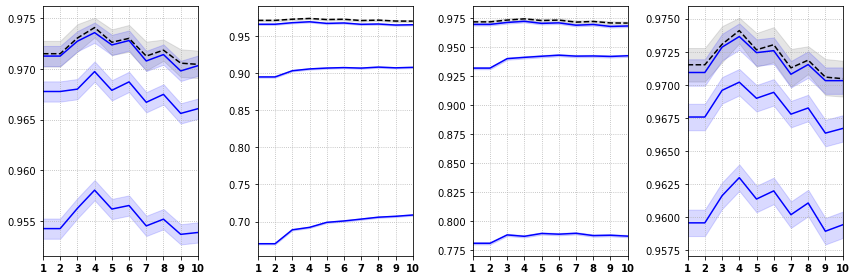

In [93]:
# tt_cv_accs = np.load('saved_bins/6_cv_accs.npy', allow_pickle=False)
# ttcvam = tt_cv_accs.mean(axis=-1)
# ttcvas = tt_cv_accs.std(axis=-1)

idx = [(0, 3), (3, 6), (6, 9), (9, 12)]

colors = ['b'] * 12

fig, ax = plt.subplots(1, 4, tight_layout=True, figsize=(12, 4))

for k, (i, j) in zip(range(4), idx):
    ax[k].grid(linestyle=':')
    ax[k].set_xticks(n_neighbors)
    ax[k].set_xticklabels(n_neighbors, fontweight='bold')
    ax[k].set_xlim(1, 10)
    ax[k].plot(n_neighbors, bl, c='black', ls='--')
    ax[k].fill_between(n_neighbors, *blbt, color='black', alpha=0.1)
    for mn, st, c in zip(ttcvam[i:j], ttcvas[i:j], colors[i:j]):
        ax[k].plot(n_neighbors, mn, c=c)
        ax[k].fill_between(n_neighbors, mn-st, mn+st, color=c, alpha=0.15)
    # ax[k].legend(legend)
# plt.savefig('n5_accs')

In [338]:
test_aug_5 = np.load('saved_bins/test_aug_5.npy', allow_pickle=False)
test_tta_6 = np.load('saved_bins/test_tta_6.npy', allow_pickle=False)
np.savetxt('56_cmp.csv', np.array([((test_aug_5 == y_test.astype(np.int)).mean(axis=-1) * 100),
    (test_tta_6 == y_test.astype(np.int)).mean(axis=-1) * 100]), fmt='%.2f')

In [339]:
tr_r = [[('r', 10)], [('r', -10)]]
tr_s = [[('s', (1, 0))], [('s', (-1, 0))], [('s', (0, 1))], [('s', (0, -1))]]
tr_g = [[('g', 1)]]
tr_rs = tr_r + tr_s
tr_rg = tr_r + tr_g
tr_sg = tr_s + tr_g
tr_rsg = tr_s + tr_s + tr_g
list_of_trs = [tr_r, tr_s, tr_g, tr_rs, tr_rg, tr_sg, tr_rsg]

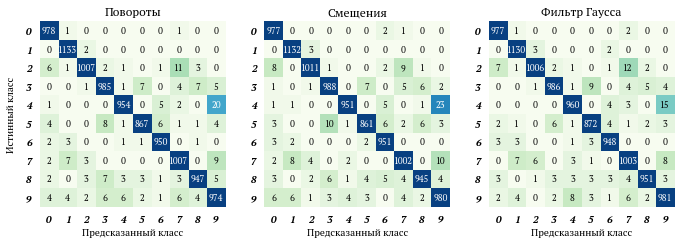

In [386]:
cms = [confusion_matrix(y_test.astype(np.int), y_pred) for y_pred in test_aug_5[:3]]
tnames = ['Повороты', 'Смещения', 'Фильтр Гаусса']
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), tight_layout=True)
for ax, cm, tm in zip(axes, cms, tnames):
    im = ax.imshow(cm, vmax=30, cmap='GnBu', aspect='equal')
    ax.grid([])
    ax.set_xticks(nums)
    ax.set_xticklabels(nums, fontstyle='italic', fontweight='bold')
    ax.set_yticks(nums)
    ax.set_yticklabels(nums, fontstyle='italic', fontweight='bold')
    ax.set_xlabel('Предсказанный класс', labelpad=4)

    ax.set_title(tm)
    for i in range(10):
        for j in range(10):
            color = 'white' if cm[j, i] > 19 else 'black'
            im.axes.text(i, j, cm[j, i], horizontalalignment='center',
            verticalalignment='center', c=color, fontsize=9)
    for spine in ax.spines.values():
            spine.set_visible(False)
    ax.tick_params(length=0, pad=8)
    plt.setp(ax.get_yticklabels(), visible=True)

axes[0].set_ylabel('Истинный класс', labelpad=10)

plt.tight_layout()
plt.savefig('vis/5_conf.pdf')

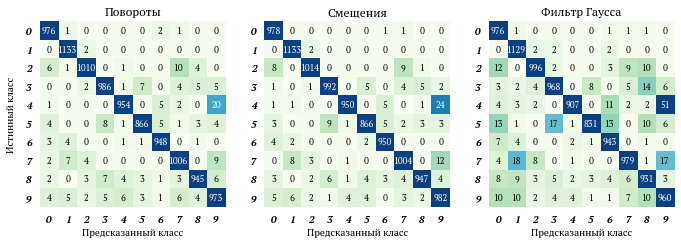

In [384]:
cms = [confusion_matrix(y_test.astype(np.int), y_pred) for y_pred in test_tta_6[:3]]
tnames = ['Повороты', 'Смещения', 'Фильтр Гаусса']
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), tight_layout=True)
for ax, cm, tm in zip(axes, cms, tnames):
    im = ax.imshow(cm, vmax=30, cmap='GnBu', aspect='equal')
    ax.grid([])
    ax.set_xticks(nums)
    ax.set_xticklabels(nums, fontstyle='italic', fontweight='bold')
    ax.set_yticks(nums)
    ax.set_yticklabels(nums, fontstyle='italic', fontweight='bold')
    ax.set_xlabel('Предсказанный класс', labelpad=4)

    ax.set_title(tm)
    for i in range(10):
        for j in range(10):
            color = 'white' if cm[j, i] > 19 else 'black'
            im.axes.text(i, j, cm[j, i], horizontalalignment='center',
            verticalalignment='center', c=color, fontsize=9)
    for spine in ax.spines.values():
            spine.set_visible(False)
    ax.tick_params(length=0, pad=8)
    plt.setp(ax.get_yticklabels(), visible=True)

axes[0].set_ylabel('Истинный класс', labelpad=10)

plt.tight_layout()
plt.savefig('vis/6_conf.pdf')